<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw1/blob/main/NNDL_hw1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

# Setup and Dataset

## Import libraries and data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from tqdm import tqdm, tqdm_notebook, notebook

from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


In [54]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
! pip install torch-optimizer
import torch_optimizer

     |████████████████████████████████| 71kB 8.7MB/s 


The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [8]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-12-29 14:06:50--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘gitlab.dei.unipd.it’
--2020-12-29 14:07:07--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv       100%[===================>]   3.70K  --.-KB/s    in 0s      

2020-12-29 14:07:07 (71.3 MB/s) - ‘regression_dataset/test_data.csv’ saved [3788/3788]



## Examples on the dataset

How to load the data:

In [9]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [10]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

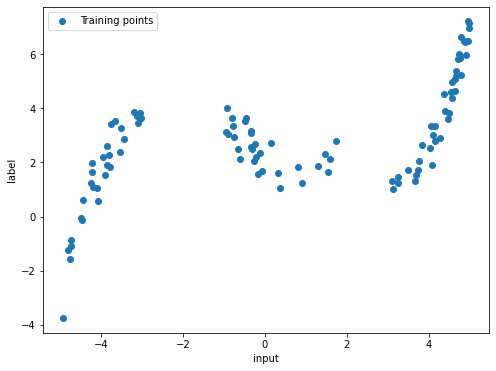

In [14]:
fig = plt.figure(figsize=(8,6))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

# Classes definition

## Dataset classes

In [21]:
class DFDataset(Dataset):

  def __init__(self, data, transform=None):
    """
    Args:
        df (pandas dataframe): x and y on 0 and 1 columns.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    #return a nparray from the dataframe
    sample = self.data.iloc[idx,:].to_numpy()
    if self.transform:
        sample = self.transform(sample)
    return sample


class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
        
composed_transform = transforms.Compose([ToTensor()])

## NN model for the regression task:

In [22]:
class RegNet(nn.Module):
    
    def __init__(self, net_params):

        super().__init__()
        # self.net_params = net_params
        Ni, Nh1, Nh2, Nh3, No = net_params[0], net_params[1], net_params[2], net_params[3], net_params[4]
        # Nh1, Nh2, Nh3= net_params[1], net_params[2], net_params[3]
        # Ni, No = 1, 1

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.out(x)
        return x

## Training loop function:



In [23]:

def training_loop(net, optimizer, loss_fn, 
                  train_dataloader, val_dataloader, n_epochs, verbose=False):
    train_loss_log = []
    val_loss_log = []
    for epoch_num in range(n_epochs):
        if verbose:
            print(f'EPOCH {epoch_num}')

        #training step
        train_loss = []
        net.train()
        for sample_batched in train_dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            #forward
            out = net(x_batch)
            #compute loss
            loss = loss_fn(out, label_batch)

            #backpropagation
            net.zero_grad()
            loss.backward()

            #update weights
            optimizer.step()

            #save train loss
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        #save average train loss
        train_loss = np.mean(train_loss)
        if verbose:
            print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)    

        #validation
        val_loss= []
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            if verbose:
                print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)    
    return train_loss_log, val_loss_log

## K-Fold training function:

In [24]:

def kfold_train(train_df, n_folds, params):

    batch_size = params['batch_size']
    n_epochs = params['n_epochs']
    opt_type = params['opt_type']

    model_record = []
    #instantiate k-fold splitter
    myKF = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    split = myKF.split(train_df)

    # val_folds = []
    ### NB it only works with 5 folds:(
    
    # train_log_df = pd.DataFrame(columns=['0','1','2','3','4'])
    # val_log_df = pd.DataFrame(columns=['0','1','2','3','4'])
    col_list = [str(x) for x in range(n_folds)]
    train_log_df = pd.DataFrame(columns=col_list)
    val_log_df = pd.DataFrame(columns=col_list)

    count_fold = 0
    for train_idx, val_idx in myKF.split(train_df):
        # print(f"Now processing fold {count_fold}\n")
        
        #split the dataframes
        train_fold = train_df.iloc[train_idx, :]
        val_fold = train_df.iloc[val_idx, :] 

        #create DFDataset object
        train_dataset = DFDataset(train_fold, transform=composed_transform)
        val_dataset = DFDataset(val_fold, transform=composed_transform)

        #create DataLoader object
        train_dataloader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=0)
        # train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
        val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

        # Initialize model
        net_params = [1] + params['net_params'] + [1]
        # print(net_params)
        net = RegNet(net_params)
        net.to(device)

        # Define the loss function
        loss_fn = nn.MSELoss()

        # Define the optimizer
        if opt_type == 0:
            optimizer = optim.Adam(net.parameters())
        elif opt_type == 1:
            optimizer = torch_optimizer.DiffGrad(net.parameters())
        elif opt_type == 2:
            optimizer = torch_optimizer.RAdam(net.parameters())

        #TRAINING LOOP
        train_loss_log, val_loss_log = training_loop(net, 
                                                     optimizer,
                                                     loss_fn,
                                                     train_dataloader, 
                                                     val_dataloader, 
                                                     n_epochs)

        # net.cpu()
        # del net
        model_record.append(net)

        train_log_df[str(count_fold)] = train_loss_log
        val_log_df[str(count_fold)] = val_loss_log

        count_fold += 1


    # avg_val_folds = sum(val_folds) / len(val_folds)

    #consider the mean in the last n_epochs//10 epochs
    # best_fold = val_log_df.iloc[-1,:].argmin()
    val_mean_result = np.zeros([n_folds,])
    for i in range(n_folds):
        val_mean_result[i] = val_log_df.iloc[-1*int(np.ceil(n_epochs/10)),i].mean()
    
    best_fold = np.argmin(val_mean_result)

    # best_fold = val_log_df.iloc[-(n_epochs//10),:].mean().argmin()
    
    best_net = model_record[best_fold]

    return train_log_df, val_log_df, best_net, best_fold
# return train_loss_log, val_loss_log

Test the classes here for debugging

In [25]:
#test
params = {'n_epochs': 5,'batch_size': 8, 'opt_type': 2, 'net_params': [128,256,128]}
train_log_df, val_log_df, _, best_fold = kfold_train(train_df=train_df, n_folds=5, params=params)

val_log_df


,0,1,2,3,4
0,7.448450,5.805412,7.305542,6.249238,8.722581
1,6.833792,5.514490,6.757502,5.731100,8.003390
2,6.060260,5.198063,6.076675,5.057004,7.088736
3,5.314198,4.969099,5.369400,4.428407,6.174942
4,4.630305,4.882167,4.697014,3.834244,5.323237


In [ ]:
print(best_fold)

3


# Grid search Training:

try optimizers from https://pythonawesome.com/a-collection-of-optimizers-for-pytorch/
Adam, DiffGrad, RAdam

In [ ]:
csv_name = "grid_result_100ep_avg02.csv"
path_out = "/content/drive/My Drive/NNDL_hw1_models/"

In [ ]:


batch_gs = np.array([4,8,16])
opt_gs = np.array([0,1,2])
Nh1_gs = np.array([512,1024])
Nh2_gs = np.array([512,1024])
Nh3_gs = np.array([512,1024])

n_folds = 5
n_epochs = 100


grid = product(batch_gs, opt_gs, Nh1_gs, Nh2_gs, Nh3_gs)
grid_df = pd.DataFrame(list(grid))
val_kfold_avg = []
#big grid search loop
for i in notebook.tqdm(range(len(grid_df))):
    params= {'n_epochs': n_epochs, 'batch_size': grid_df.iloc[i,0], 'opt_type': grid_df.iloc[i,1], 'net_params': list(grid_df.iloc[i,2:5]) }
    # print(params)
    train_log_df, val_log_df, _, _ = kfold_train(train_df=train_df, n_folds=n_folds, params=params)
    
    val_mean_result = np.zeros([n_folds,])
    for i in range(n_folds):
        val_mean_result[i] = val_log_df.iloc[-1*int(np.ceil(n_epochs/10)),i].mean()
    val_avg = np.mean(val_mean_result)
    val_kfold_avg.append(val_avg)

    # val_kfold_avg.append(np.mean(val_log_df.iloc[-1,:].to_numpy()))
    # print(val_kfold_avg)
    # print(val_log_df)
    if i%5==0:
        grid_result = grid_df.iloc[:len(val_kfold_avg),:]
        grid_result['val_kfold_avg'] = val_kfold_avg
        grid_result.to_csv(path_out+csv_name)

grid_result = grid_df.copy()
grid_result['val_kfold_avg'] = val_kfold_avg





grid_result.to_csv(path_out+csv_name)

## Analysis of the grid search results



In [ ]:
grid_result = pd.read_csv(path_out+csv_name, usecols=[str(x) for x in range(5)]+[ 'val_kfold_avg'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(grid_result)

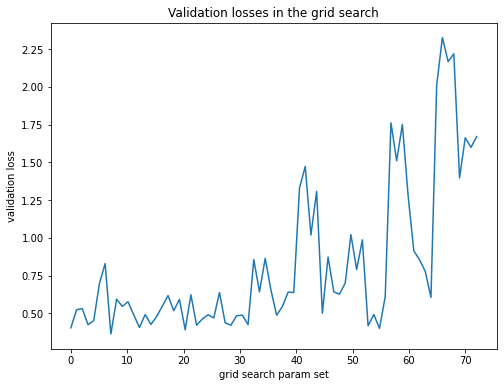

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

# ax.grid_result['val_kfold_avg'].plot()
ax.plot(np.linspace(0,len(grid_result), len(grid_result)), grid_result['val_kfold_avg'])
ax.set_title('Validation losses in the grid search')
ax.set_xlabel('grid search param set')
ax.set_ylabel('validation loss')
fig.show()

In [ ]:
#sort to have the better performance at first
grid_result = grid_result.sort_values(by='val_kfold_avg', )
grid_result

,0,1,2,3,4,val_kfold_avg
7,4,0,1024,1024,1024,0.363525
20,4,2,1024,512,512,0.391689
54,16,0,1024,1024,512,0.400870
0,4,0,512,512,512,0.404587
12,4,1,1024,512,512,0.406756
...,...,...,...,...,...,...
56,16,1,512,512,512,1.762333
64,16,2,512,512,512,2.011244
66,16,2,512,1024,512,2.167745
67,16,2,512,1024,1024,2.219271


keep the best parameters

In [18]:
best_params={'n_epochs': 100, 'batch_size': 4, 'opt_type': 0, 'net_params': [1024, 1024, 1024]}

In [ ]:
best_params = {'n_epochs': 100, 'batch_size': grid_result.iloc[0,0], 'opt_type': grid_result.iloc[0,1], 'net_params': list(grid_result.iloc[0,2:5].to_numpy(dtype=int)) }
print(best_params)

{'n_epochs': 100, 'batch_size': 4, 'opt_type': 0, 'net_params': [1024, 1024, 1024]}


In [26]:
# best_params = grid_result.iloc[0, 1:5].to_numpy(dtype=int)

train_log_df, val_log_df, best_net, best_fold = kfold_train(train_df=train_df, n_folds=5, params=best_params)
# best_fold = val_log_df.iloc[-1,:].argmin()

In [27]:
val_log_df


,0,1,2,3,4
0,1.734555,5.934887,3.189819,2.752639,2.448254
1,2.058665,6.391023,3.005953,2.473196,2.869258
2,3.218344,5.753088,3.023757,2.196316,3.886791
3,3.138462,5.389241,4.158001,2.402773,2.348925
4,3.489235,4.046811,3.111537,2.042838,2.565624
...,...,...,...,...,...
95,0.212380,0.820080,0.524460,0.243071,0.332952
96,0.275190,1.536725,0.249994,0.280749,1.045005
97,0.600620,0.893119,0.487657,0.248212,0.347060
98,0.347683,0.781439,0.898418,0.356228,1.286106


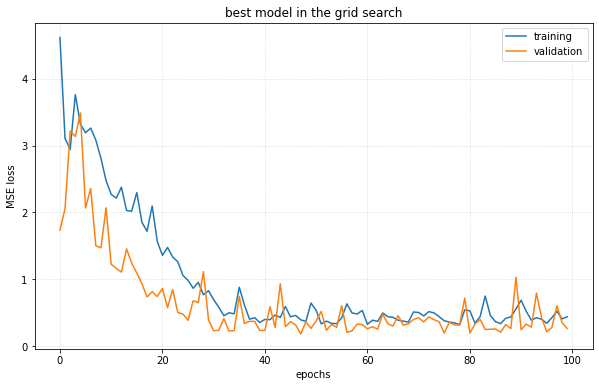

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("best model in the grid search")
ax.plot(train_log_df.iloc[:,best_fold], label="training")
ax.plot(val_log_df.iloc[:,best_fold], label="validation")
ax.grid(color='lightgrey' , linestyle=':')
ax.set_ylabel("MSE loss")
ax.set_xlabel("epochs")

ax.legend()

fig.show()

# Training the best model on the entire dataset

In [30]:

batch_size = best_params['batch_size']
n_epochs = best_params['n_epochs']
opt_type = best_params['opt_type']
net_params = [1] + best_params['net_params'] + [1]

#create DFDataset object
train_dataset = DFDataset(train_df, transform=composed_transform)
test_dataset = DFDataset(test_df, transform=composed_transform)

#create DataLoader object
# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Initialize model

net = RegNet(net_params)
net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
if opt_type == 0:
    optimizer = optim.Adam(net.parameters())
elif opt_type == 1:
    optimizer = torch_optimizer.DiffGrad(net.parameters())
elif opt_type == 2:
    optimizer = torch_optimizer.RAdam(net.parameters())

#TRAINING LOOP
train_loss_log, test_loss_log = training_loop(net, 
                                                optimizer,
                                                loss_fn,
                                                train_dataloader, 
                                                test_dataloader, 
                                                n_epochs)


Final loss in the test set: 0.32125166058540344


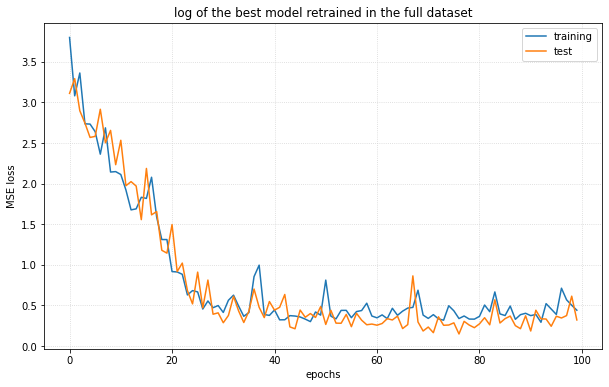

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("log of the best model retrained in the full dataset")
ax.plot(train_loss_log, label="training")
ax.plot(test_loss_log, label="test")
ax.grid(color='lightgrey' , linestyle=':')
ax.set_ylabel("MSE loss")
ax.set_xlabel("epochs")

ax.legend()

fig.show()

print(f"Final loss in the test set: {test_loss_log[-1]}")

## confront the function found with the dataset  

In [56]:
#make a linear space dataset 
N = 1000
lin_set = np.zeros([N,2])
lin_set[:,0] = np.linspace(np.min(test_df.input), np.max(test_df.input), N)
lin_set[:,1] = np.linspace(np.min(test_df.label), np.max(test_df.label), N)
lin_set_df = pd.DataFrame(lin_set)

In [58]:

lin_dataset = DFDataset(lin_set_df, transform=composed_transform)
lin_dataloader = DataLoader(lin_dataset, batch_size=len(lin_dataset), shuffle=False, num_workers=0)
loss_fn = nn.MSELoss()
net.to(device)
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in lin_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)
        out = out.detach().cpu().numpy()

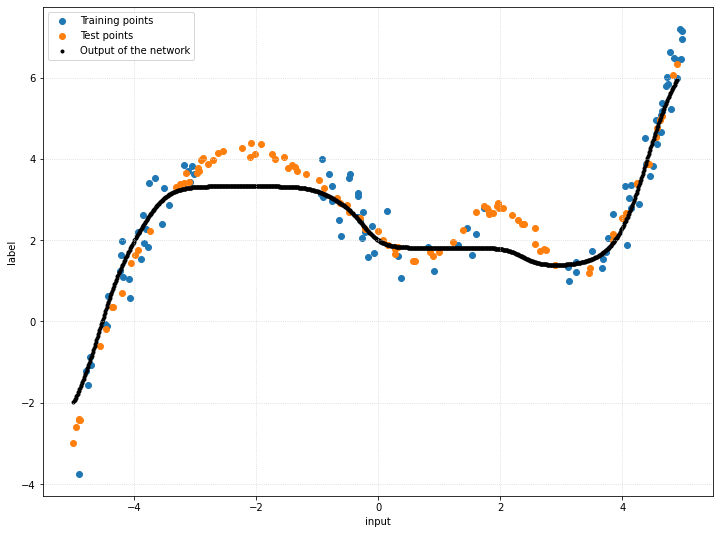

In [59]:
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(train_df.input, train_df.label, label='Training points')
ax.scatter(test_df.input, test_df.label, label='Test points')
ax.set_xlabel('input')
ax.set_ylabel('label')
ax.scatter(lin_set[:,0], out, marker='.', color='black', label='Output of the network')
ax.legend()
ax.grid(linestyle=':', color='lightgrey')
plt.show()

print()

# Visualization on the model features

In [37]:
#this is for conv
# kernels1 = net.lin.weight.detach().clone()

# kernels1 = kernels1 - kernels1.min()
# kernels1 = kernels1 / kernels1.max()
# filter_img = torchvision.utils.make_grid(kernels1, nrow=8)
# plt.imshow(filter_img.permute(1,2,0))

torch.Size([1024, 1])
torch.Size([1024, 1024])
torch.Size([1024, 1024])
torch.Size([1024, 1])


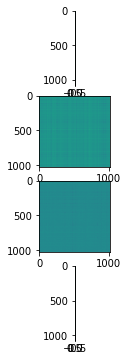

In [53]:
import torchvision
net.to(torch.device('cpu'))

def normalize01(x):
    y = x-x.min()
    y = y/y.max()
    return y 

fc1 = normalize01(net.fc1.weight.detach().clone())


fc2 = normalize01(net.fc2.weight.detach().clone())
fc3 = normalize01(net.fc3.weight.detach().clone())
out = normalize01(net.out.weight.detach().clone()).T

print(np.shape(fc1))
print(np.shape(fc2))
print(np.shape(fc3))
print(np.shape(out))

fig, ax = plt.subplots(4,1, figsize=(12,6))
# ax[0].imshow(fc1)
# ax[1].imshow(fc2)
# ax[2].imshow(fc3)
# ax[3].imshow(out)

# print(fc1)
# plt.plot(fc1)
filter_img = torchvision.utils.make_grid(fc1, nrow=8)
# plt.imshow(filter_img.permute(1,2,0))